## <b> Predictive Model </b>

We will build a predictive model that will be able to predict the successful bookings using customer bookings data.

In [1]:
# Import necessary libraries 
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,  RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.inspection import permutation_importance

In [2]:
cwd = os.getcwd()

df = pd.read_csv(cwd + "/data_t2/filtered_customer_booking.csv", index_col=0)

In [3]:
df = df.reset_index(drop=True)
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,Internet,RoundTrip,27,6,9,6,PERPNH,Australia,1,0,1,5.62,0
49978,1,Internet,RoundTrip,111,6,4,7,PERPNH,Australia,0,0,0,5.62,0
49979,1,Internet,RoundTrip,24,6,22,6,PERPNH,Australia,0,0,1,5.62,0
49980,1,Internet,RoundTrip,15,6,11,1,PERPNH,Australia,1,0,1,5.62,0


In [4]:
df_final = df

The purpose of this cell is to perform one-hot encoding on the categorical columns "sales_channel" and "trip_type" in the DataFrame. 

One-hot encoding is used to transform categorical variables into a binary representation, where each unique category becomes a separate binary column. 

This type of encoding is necessary for certain machine learning algorithms that require numerical inputs, enabling them to effectively process and learn from categorical data.

In [5]:
# One hot encode the categorical columns

#create instance of one hot encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#one hot encode Sales Channel
encoder_df = pd.DataFrame(encoder.fit_transform(df[["sales_channel"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'Internet', 1:'Mobile'})
df_final = df_final.join(encoder_df)

#one hot encode trip type
encoder_df = pd.DataFrame(encoder.fit_transform(df[["trip_type"]]).toarray())
encoder_df = encoder_df.rename(columns={0:'RoundTRip', 1:'OneWayTrip',2:'CircleTrip'})
df_final = df_final.join(encoder_df)

In [6]:
#drop categorical columns now
df_final.drop(['sales_channel', 'trip_type','booking_origin', 'route'], axis=1, inplace = True)

In [7]:
#store the label for supervised learning
label = df['booking_complete']

In [8]:
df_final = df_final.drop('booking_complete', axis=1)
df_final

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip
0,2,262,19,7,6,1,0,0,5.52,1.0,0.0,0.0,0.0,1.0
1,1,112,20,3,6,0,0,0,5.52,1.0,0.0,0.0,0.0,1.0
2,2,243,22,17,3,1,1,0,5.52,1.0,0.0,0.0,0.0,1.0
3,1,96,31,4,6,0,0,1,5.52,1.0,0.0,0.0,0.0,1.0
4,2,68,22,15,3,1,0,1,5.52,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,2,27,6,9,6,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49978,1,111,6,4,7,0,0,0,5.62,1.0,0.0,0.0,0.0,1.0
49979,1,24,6,22,6,0,0,1,5.62,1.0,0.0,0.0,0.0,1.0
49980,1,15,6,11,1,1,0,1,5.62,1.0,0.0,0.0,0.0,1.0


### <b> Normalizing the values

In [9]:
#create a standard scaler object
scaler = StandardScaler()

#fit and transform the data
scaled_df = scaler.fit_transform(df_final)

#create a dataframe of scaled data
scaled_df = pd.DataFrame(scaled_df, columns = df_final.columns)

# add the labels back to the dataframe
scaled_df['label']  = label

scaled_df

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,0.400769,1.971093,-0.119401,-0.381588,1.096876,0.703587,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,-0.579424,0.302987,-0.089895,-1.120618,1.096876,-1.421288,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,0.400769,1.759799,-0.030885,1.465988,-0.408618,0.703587,1.538334,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
3,-0.579424,0.125056,0.234662,-0.935861,1.096876,-1.421288,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
4,0.400769,-0.186323,-0.030885,1.096473,-0.408618,0.703587,-0.650054,1.158002,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49977,0.400769,-0.642272,-0.502969,-0.012073,1.096876,0.703587,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49978,-0.579424,0.291867,-0.502969,-0.935861,1.598707,-1.421288,-0.650054,-0.863557,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49979,-0.579424,-0.675634,-0.502969,2.389776,1.096876,-1.421288,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
49980,-0.579424,-0.775721,-0.502969,0.357443,-1.412280,0.703587,-0.650054,1.158002,-1.107240,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0


### <b> Correlation Matrix

<AxesSubplot:>

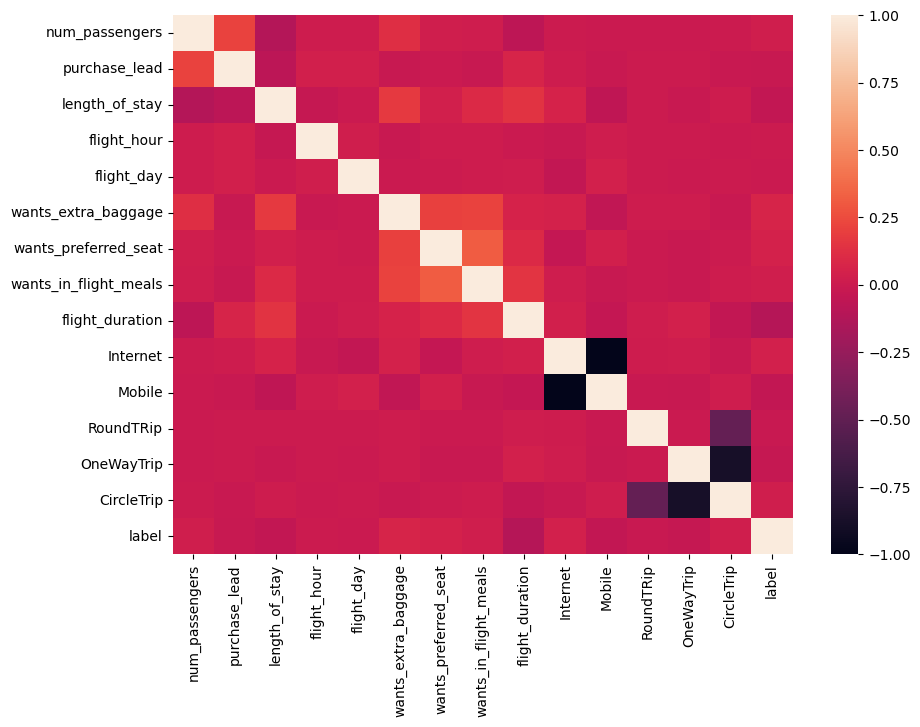

In [10]:
corr = scaled_df.corr()

plt.figure(figsize=(10,7))

#plot the heatmap
sns.heatmap(corr)

#### <b> Split the data into train and test sets

In [11]:
X = scaled_df.iloc[:, :-1].values
y = scaled_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [12]:
"""
    Create functions to fit and predict the values of whether customer would complete the booking.
    Also functions with metrics to evaluate the model prediction.

"""

def model_fit_predict(model, X, y, X_predict):
    model.fit(X, y)
    return model.predict(X_predict)

def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def pre_score(y_true, y_pred):
    return precision_score(y_true, y_pred)

def f_score(y_true, y_pred):
    return f1_score(y_true, y_pred)

### <b> Random Forest Classifier

In [13]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

#### <b> Checking the train accuracy

In [14]:
y_pred_train = model_fit_predict(clf_rf, X_train, y_train, X_train)
set(y_pred_train)

#f1 score for training data
f1 = round(f1_score(y_train, y_pred_train),2) 

#accuracy score for training data
acc = round(accuracy_score(y_train, y_pred_train),2) 

#precision score for training data
pre = round(precision_score(y_train, y_pred_train),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")

Accuracy, precision and f1-score for training data are 0.93, 1.0 and 0.72 respectively


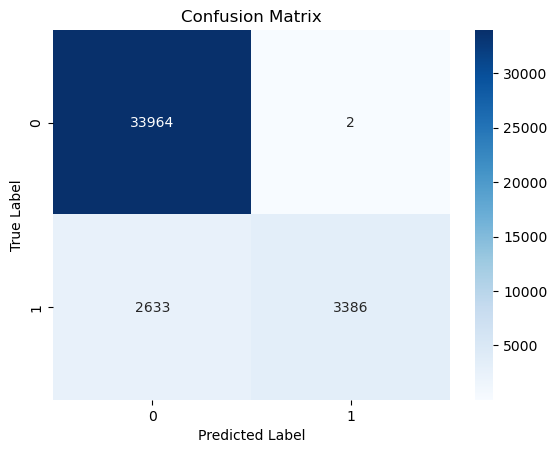

Training Accuracy: 0.9341002876078529


In [20]:
# Score the confusion matrix on the training data
y_pred_train = clf_rf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", accuracy)

#### <b> Checking the test accuracy

In [16]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(max_depth =50 , min_samples_split=5,random_state=0)

y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

print(f"Accuracy, precision and f1-score for training data are {acc}, {pre} and {f1} respectively")


Accuracy, precision and f1-score for training data are 0.86, 0.56 and 0.07 respectively


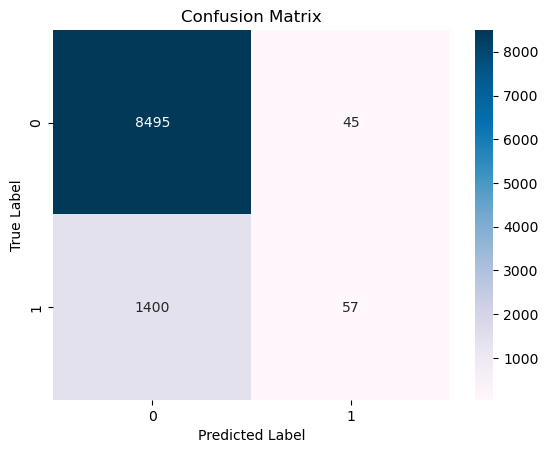

Test Accuracy: 0.8554566369910973


In [19]:
# Score the confusion matrix on the test data
y_pred_test = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="PuBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy)

Text(0.5, 0, 'Random Forest Feature Importance')

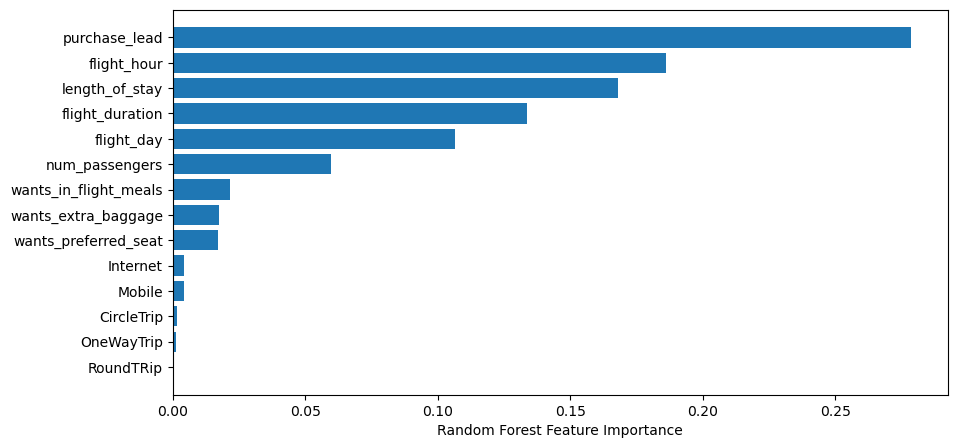

In [21]:
plt.figure(figsize=(10,5))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### <b> Balancing the dataset

In [22]:
scaled_df.label.value_counts()

0    42506
1     7476
Name: label, dtype: int64

In [23]:
#create a dataframe having all labels 0 with 10000 samples
scaled_df_0 = scaled_df[scaled_df.label ==0].sample(n=8000)

In [24]:
#concatenate the two dataframee, one havng all labels 0 and other having all labels as 1
scaled_df_new = pd.concat([scaled_df[scaled_df.label==1], scaled_df_0], ignore_index=True)

In [25]:
#shuffle the dataframe rows
scaled_df_new = scaled_df_new.sample(frac = 1).reset_index(drop=True)
scaled_df_new

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,Internet,Mobile,RoundTRip,OneWayTrip,CircleTrip,label
0,2.361155,-0.686755,-0.502969,-0.935861,1.096876,0.703587,-0.650054,-0.863557,-1.174049,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
1,1.380962,0.658850,-0.532474,1.281231,-1.412280,0.703587,-0.650054,1.158002,-1.300985,0.355786,-0.355786,-0.048231,-0.088336,0.100826,0
2,-0.579424,-0.898048,1.178830,0.172685,-0.408618,0.703587,-0.650054,-0.863557,-1.688475,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
3,-0.579424,0.959109,0.146147,-1.305376,-0.408618,0.703587,-0.650054,-0.863557,-0.439155,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
4,-0.579424,-0.419858,1.060809,0.911715,1.598707,0.703587,-0.650054,1.158002,0.930420,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15471,-0.579424,-0.664514,-0.502969,0.542200,0.595045,-1.421288,-0.650054,-0.863557,-1.741921,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
15472,-0.579424,-0.508824,-0.532474,-0.196830,-1.412280,0.703587,-0.650054,-0.863557,-0.572772,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
15473,0.400769,1.059195,-0.561979,0.357443,0.595045,0.703587,1.538334,1.158002,1.037314,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1
15474,-0.579424,-0.753479,-0.561979,0.726958,-0.910449,-1.421288,-0.650054,1.158002,-1.300985,0.355786,-0.355786,-0.048231,-0.088336,0.100826,1


In [26]:
X = scaled_df_new.iloc[:,:-1]
y = scaled_df_new['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [27]:
#create an instance of the classifier and fit the training data
clf_rf = RandomForestClassifier(n_estimators=50,max_depth =50 , min_samples_split=5,random_state=0)

In [28]:
y_pred_test = model_fit_predict(clf_rf, X_train, y_train, X_test)

#f1 score for training data
f1 = round(f1_score(y_test, y_pred_test),2) 

#accuracy score for training data
acc = round(accuracy_score(y_test, y_pred_test),2) 

#precision score for training data
pre = round(precision_score(y_test, y_pred_test),2) 

recall = round(recall_score(y_test, y_pred_test),2)

specificity = round(recall_score(y_test, y_pred_test, pos_label=0),2)

print(f"Accuracy, precision, recall and f1-score for training data are {acc}, {pre}, {recall}, {specificity} and {f1} respectively") 


Accuracy, precision, recall and f1-score for training data are 0.62, 0.61, 0.58, 0.65 and 0.6 respectively


Text(0.5, 0, 'Random Forest Feature Importance')

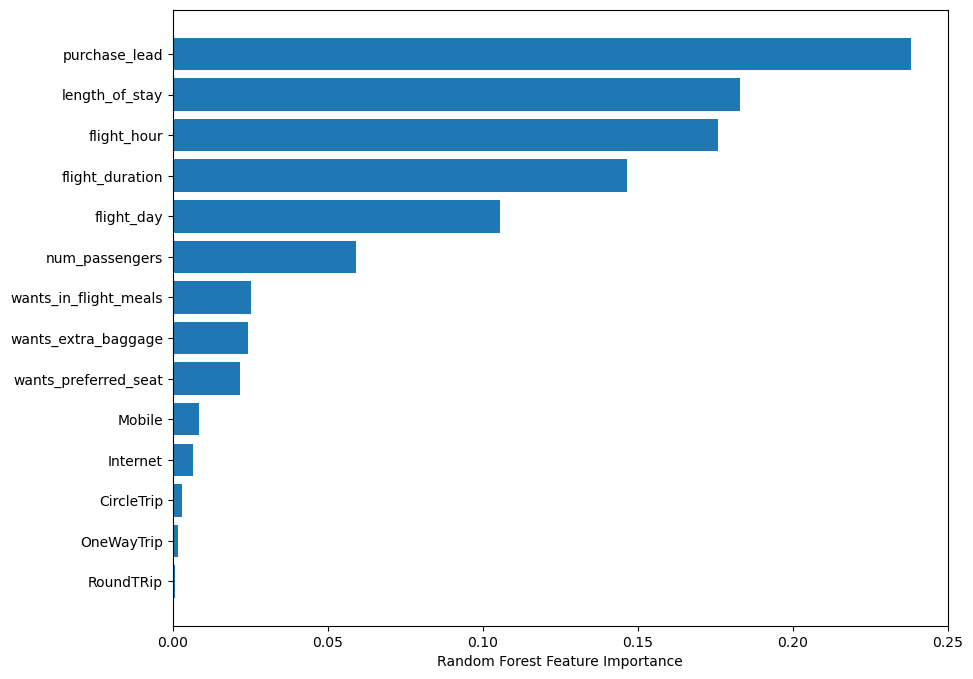

In [29]:
plt.figure(figsize=(10,8))
sorted_idx = clf_rf.feature_importances_.argsort()
plt.barh(scaled_df.iloc[:,:-1].columns[sorted_idx], clf_rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")